In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 94% 313M/331M [00:00<00:00, 793MB/s] 
100% 331M/331M [00:00<00:00, 800MB/s]


In [3]:
import zipfile
zip = zipfile.ZipFile('/content/utkface-new.zip')
zip.extractall('/content')
zip.close()

In [4]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'
age = []
gender = []
imp_path = []
for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  imp_path.append(os.path.join(folder_path,file))

In [6]:
len(age)

23708

In [7]:
df = pd.DataFrame({'age' : age,'gender' : gender , 'img' : imp_path })

In [8]:
df['age'] = df['age'].astype('float32')
df['gender'] = df['gender'].astype('float32')

In [9]:
df.head()

,age,gender,img
0,32.0,0.0,/content/utkface_aligned_cropped/UTKFace/32_0_...
1,37.0,0.0,/content/utkface_aligned_cropped/UTKFace/37_0_...
2,26.0,0.0,/content/utkface_aligned_cropped/UTKFace/26_0_...
3,66.0,0.0,/content/utkface_aligned_cropped/UTKFace/66_0_...
4,21.0,1.0,/content/utkface_aligned_cropped/UTKFace/21_1_...


In [10]:
train_df = df.sample(frac = 1 , random_state=0).iloc[:20000]
test_df = df.sample(frac = 1 , random_state=0).iloc[20000:]

In [11]:
train_datadgen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [12]:
train_generator = train_datadgen.flow_from_dataframe(
    train_df ,
    directory = None,
    x_col = 'img',
    y_col = ['age','gender'],
    target_size = (200,200),
    class_mode = 'raw',
    batch_size = 32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df ,
    directory = None,
    x_col = 'img',
    y_col = ['age','gender'],
    target_size = (200,200),
    class_mode = 'raw',
    batch_size = 32
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [13]:
def wrap(gen):
    while True:
        X, y = next(gen)
        yield X, {
            'age': y[:, 0].astype('float32'),
            'gender': y[:, 1].astype('float32'),
        }

train_gen = wrap(train_generator)
test_gen = wrap(test_generator)


In [14]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [15]:
vggnet = VGG16(include_top = False,input_shape=(200,200,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
vggnet.trainable = False

output = vggnet.layers[-1].output

flatten = Flatten()(output)

dense1 = Dense(512,activation='relu')(flatten)
dense2 = Dense(256,activation='relu')(dense1)
output1 = Dense(1,activation='linear',name='age')(dense2)

dense3 = Dense(256,activation='relu')(flatten)
dense4 = Dense(128,activation='relu')(dense3)
output2 = Dense(1,activation='sigmoid',name='gender')(dense4)

In [17]:
model = Model(outputs=[output1,output2],inputs=vggnet.input)

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 200, 200,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 200, 200,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 100, 100,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 100, 100,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 100, 100,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 50, 50,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 50, 50,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 50, 50,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 50, 50,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 25, 25,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 25, 25,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 25, 25,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 25, 25,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 12, 12,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 12, 12,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 12, 12,    │  2,359,808 │ block5_conv1[0][

 Total params: 29,035,842 (110.76 MB)

 Trainable params: 14,321,154 (54.63 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

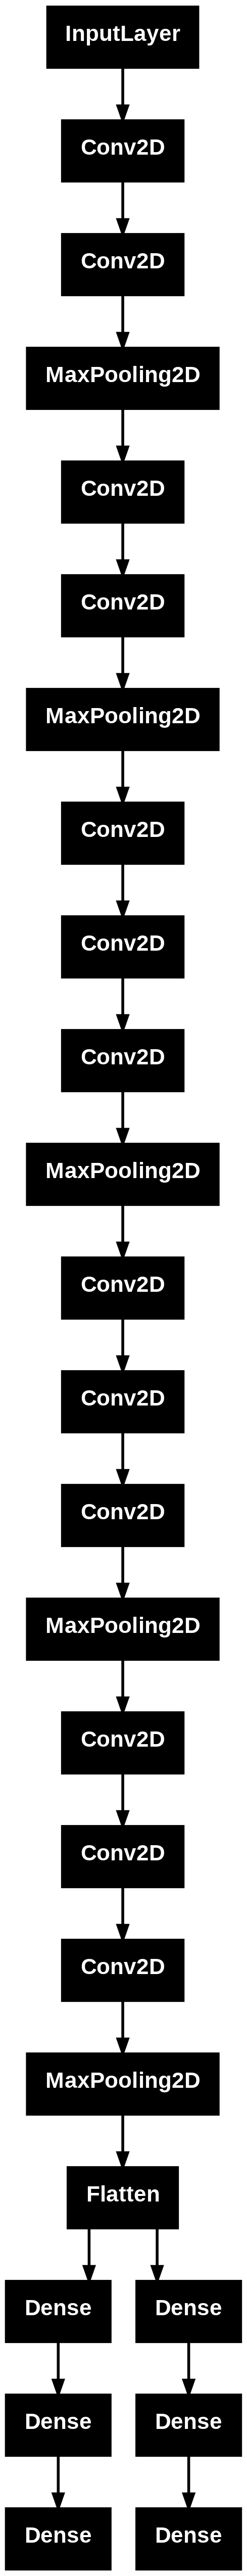

In [19]:
from keras.utils import plot_model
plot_model(model)

In [20]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'})

In [21]:
steps = len(train_generator)
val_steps = len(test_generator)
model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=steps,
    validation_steps=val_steps,
    epochs=10
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 257s 389ms/step - age_loss: 12.2140 - age_mae: 12.2140 - gender_accuracy: 0.6829 - gender_loss: 0.6433 - loss: 12.8573 - val_age_loss: 8.8394 - val_age_mae: 8.8398 - val_gender_accuracy: 0.8317 - val_gender_loss: 0.3735 - val_loss: 9.2133
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 251s 402ms/step - age_loss: 9.4313 - age_mae: 9.4313 - gender_accuracy: 0.7885 - gender_loss: 0.4446 - loss: 9.8758 - val_age_loss: 8.3696 - val_age_mae: 8.3696 - val_gender_accuracy: 0.8324 - val_gender_loss: 0.3752 - val_loss: 8.7448
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - age_loss: 8.9752 - age_mae: 8.9752 - gender_accuracy: 0.7975 - gender_loss: 0.4271 - loss: 9.4023 - val_age_loss: 9.8523 - val_age_mae: 9.8523 - val_gender_accuracy: 0.7904 - val_gender_loss: 0.4165 - val_loss: 10.2688
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 370ms/step - age_loss: 8.8684 - age_mae: 8.8684 - gender_accuracy: 0.8097 - gender_loss: 0.4048 - loss: 9.2732 - val_age_lo

Saving yash_test2.jpg to yash_test2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


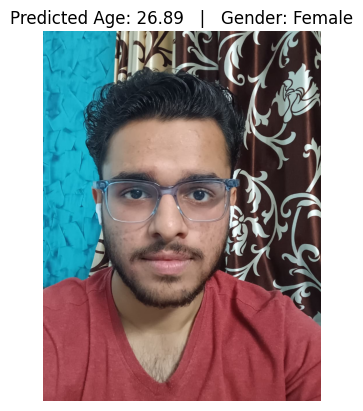

Predicted Age: 26.89
Predicted Gender: Female


In [23]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_age_gender(model, img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (200, 200))
    img_norm = img_resized.astype('float32') / 255.0

    img_input = np.expand_dims(img_norm, axis=0)

    age_pred, gender_pred = model.predict(img_input)

    age = round(float(age_pred[0][0]), 2)
    gender = "Male" if gender_pred[0][0] > 0.5 else "Female"

    return img, age, gender



uploaded = files.upload()


for file_name in uploaded.keys():
    img, age, gender = predict_age_gender(model, file_name)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Age: {age}   |   Gender: {gender}")
    plt.show()

    print("Predicted Age:", age)
    print("Predicted Gender:", gender)
